In this notebook, I added the random walk process to a randomly selected sources among the ICRF3 defing source list and computed the global spin of the CRF.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join

# My progs
from my_progs.vlbi.ts_func import get_ts
from tool_func import vsh_fit_for_pm, random_walk
from linear_fit import linfit2d

np.random.seed(3)

In [2]:
apm_all = Table.read("../data/ts_nju_pm_fit_10sigma-10step.dat", format="ascii.csv")

# convert mas/yr into muas/yr
apm_all["pmra"] = apm_all["pmra"] * 1e3
apm_all["pmra_err"] = apm_all["pmra_err"] * 1e3
apm_all["pmdec"] = apm_all["pmdec"] * 1e3
apm_all["pmdec_err"] = apm_all["pmdec_err"] * 1e3

In [3]:
icrf3_def = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")

In [4]:
mask = apm_all["num_cln"] >= 5
apm_all = apm_all[mask]

apm_def = join(icrf3_def, apm_all, keys="iers_name")

In [5]:
sample_size = 100

sou_idx = random.choices(np.arange(len(apm_def)), k=sample_size)

In [6]:
resample_wx = np.zeros(sample_size)
resample_wy = np.zeros(sample_size)
resample_wz = np.zeros(sample_size)
resample_w = np.zeros(sample_size)
resample_ra = np.zeros(sample_size)
resample_dec = np.zeros(sample_size)

In [7]:
for i, idx in enumerate(sou_idx):
    # Get the name for the selected source
    sou_name = apm_def["iers_name"][idx]

    # Coordinate time series for the source
    coordts = get_ts(
        sou_name,
        data_dir="/Users/Neo/Astronomy/data/vlbi/nju/series-10step",
        calc_oft=True)

    # Add random walk process to the coordinate time series for this source
    dra_rw, ddec_rw = random_walk(coordts["jyear"], t_scale=5, sigma_var=2)

    # Form the new coordinate offset series
    coordts["dra"] = coordts["dra"] + dra_rw
    coordts["ddec"] = coordts["ddec"] + ddec_rw

    # Re-fit the apparent proper motion
    res1 = linfit2d(coordts["jyear"] - np.median(coordts["jyear"]),
                    coordts["dra"],
                    coordts["ddec"],
                    x_err=coordts["ra_err"],
                    y_err=coordts["dec_err"],
                    xy_cor=coordts["ra_dec_corr"],
                    fit_type="sep")

    # Update the APM data
    apm_def["pmra"][idx] = res1["x1"] * 1e3
    apm_def["pmra_err"][idx] = res1["x1_err"] * 1e3
    apm_def["pmdec"][idx] = res1["y1"] * 1e3
    apm_def["pmdec_err"][idx] = res1["y1_err"] * 1e3
    apm_def["pmra_pmdec_cor"][idx] = res1["x1y1_cor"]
    

    # VSH fitting
    pmt, sig, output = vsh_fit_for_pm(apm_def)

    # Record the results
    resample_wx[i] = pmt[0]
    resample_wy[i] = pmt[1]
    resample_wz[i] = pmt[2]
    resample_w[i] = pmt[3]
    resample_ra[i] = output["R_ra"]
    resample_dec[i] = output["R_dec"]

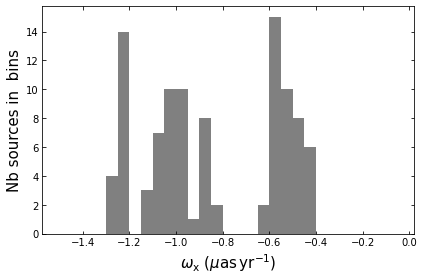

In [21]:
bin_size = 0.05
bin_array = np.arange(-1.5, 0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wx,
        bins=bin_array,
        color="grey",
        label="All")


ax.set_xlabel("$\\omega_{\\rm x}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()
# plt.savefig("../plots/spin-x-from-resampled-apm.eps")

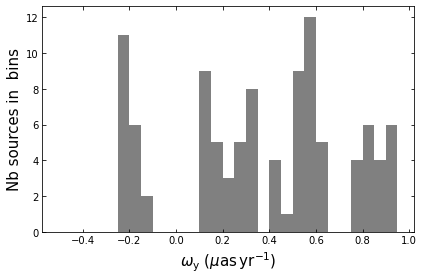

In [23]:
bin_size = 0.05
bin_array = np.arange(-.5, 1.0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wy,
        bins=bin_array,
        color="grey",
        label="All")

ax.set_xlabel("$\\omega_{\\rm y}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()
# plt.savefig("../plots/spin-y-from-resampled-apm.eps")

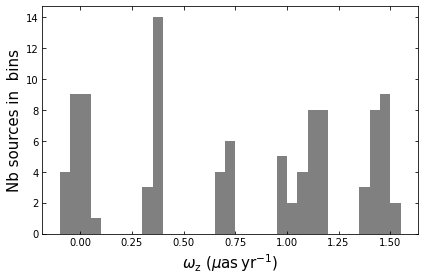

In [29]:
bin_size = 0.05
bin_array = np.arange(-.1, 1.6, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wz,
        bins=bin_array,
        color="grey",
        label="All")

# ax.plot(bin_array, rvs_wz.pdf(bin_array)*sample_num*bin_size, "r--")

# ax.text(-2., 55, "$\mu={:+.2f}$".format(mu_wz), fontsize=15)
# ax.text(-2., 45, "$\sigma={:.2f}$".format(std_wz), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm z}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()
# plt.savefig("../plots/spin-z-from-resampled-apm.eps")

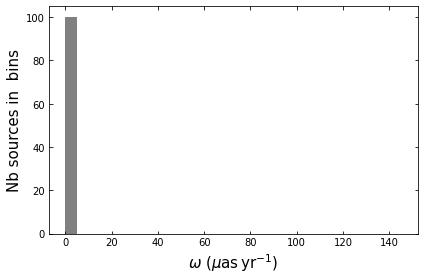

In [11]:
bin_size = 5
bin_array = np.arange(0, 150, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_w,
        bins=bin_array,
        color="grey",
        label="All")


ax.set_xlabel("$\\omega$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

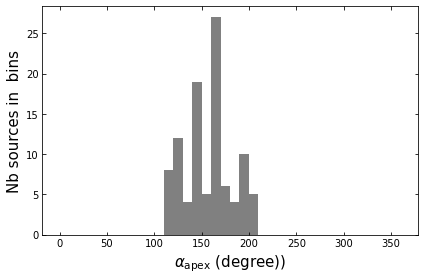

In [12]:
bin_size = 10
bin_array = np.arange(0, 361, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_ra,
        bins=bin_array,
        color="grey",
        label="All")

# ax.plot(bin_array, rvs_ra.pdf(bin_array)*sample_num*bin_size, "r--")

# ax.text(0, 75, "$\mu={:.0f}$".format(mu_ra), fontsize=15)
# ax.text(0, 65, "$\sigma={:.0f}$".format(std_ra), fontsize=15)

ax.set_xlabel("$\\alpha_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

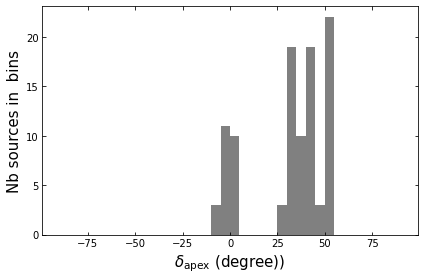

In [13]:
bin_size = 5
bin_array = np.arange(-90, 91, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_dec,
        bins=bin_array,
        color="grey",
        label="All")

# ax.plot(bin_array, rvs_dec.pdf(bin_array)*sample_num*bin_size, "r--")

# ax.text(-80, 85, "$\mu={:-.0f}$".format(mu_dec), fontsize=15)
# ax.text(-80, 75, "$\sigma={:.0f}$".format(std_dec), fontsize=15)

ax.set_xlabel("$\\delta_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()